In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [2]:
df = pd.read_csv("diabetes_dataset.csv")
df

,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,...,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,...,41,160,145,136,236,6.36,8.18,29.6,Type 2,1
1,48,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,...,55,50,30,93,150,2.00,5.63,23.0,No Diabetes,0
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,...,66,99,36,118,195,5.07,7.51,44.7,Type 2,1
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,...,50,79,140,139,253,5.28,9.03,38.2,Type 2,1
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,...,52,125,160,137,184,12.74,7.20,23.5,Type 2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,46,Male,Other,Graduate,Upper-Middle,Unemployed,Former,1,136,8.3,...,45,150,116,113,109,14.58,5.55,26.0,Pre-Diabetes,0
99996,41,Female,White,Graduate,Middle,Employed,Never,3,76,8.8,...,55,123,146,96,146,9.02,5.97,24.4,Pre-Diabetes,0
99997,57,Female,Black,No formal,Upper-Middle,Employed,Former,4,121,9.9,...,50,111,184,93,132,2.57,5.21,27.6,No Diabetes,0
99998,47,Female,Black,Highschool,Lower-Middle,Retired,Never,3,52,5.9,...,68,91,116,106,117,9.81,5.53,26.4,Pre-Diabetes,0


In [3]:
df.columns

Index(['age', 'gender', 'ethnicity', 'education_level', 'income_level',
       'employment_status', 'smoking_status', 'alcohol_consumption_per_week',
       'physical_activity_minutes_per_week', 'diet_score',
       'sleep_hours_per_day', 'screen_time_hours_per_day',
       'family_history_diabetes', 'hypertension_history',
       'cardiovascular_history', 'bmi', 'waist_to_hip_ratio', 'systolic_bp',
       'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol',
       'ldl_cholesterol', 'triglycerides', 'glucose_fasting',
       'glucose_postprandial', 'insulin_level', 'hba1c', 'diabetes_risk_score',
       'diabetes_stage', 'diagnosed_diabetes'],
      dtype='object')

In [4]:
cols_to_drop = ['education_level', 'employment_status', 'income_level', 'waist_to_hip_ratio', 'ldl_cholesterol', 'hdl_cholesterol', 'hba1c', 'diabetes_risk_score', 'smoking_status', 'ethnicity', 'cardiovascular_history']
df = df.drop(columns=cols_to_drop)

In [5]:
df.columns

Index(['age', 'gender', 'alcohol_consumption_per_week',
       'physical_activity_minutes_per_week', 'diet_score',
       'sleep_hours_per_day', 'screen_time_hours_per_day',
       'family_history_diabetes', 'hypertension_history', 'bmi', 'systolic_bp',
       'diastolic_bp', 'heart_rate', 'cholesterol_total', 'triglycerides',
       'glucose_fasting', 'glucose_postprandial', 'insulin_level',
       'diabetes_stage', 'diagnosed_diabetes'],
      dtype='object')

In [6]:
# Separate features and target
target_col = "diagnosed_diabetes"
X = df.drop(target_col, axis=1)
y = df[target_col].astype(bool)

In [ ]:
'''Given a list of features, create a LR model and evaluate it.'''
def lr_model(features: list, model_num: int, max_iterations: int):
  x = X[features]

  # split the set into test and train
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

  # Construct the pipeline
  preproc = make_column_transformer(
      (StandardScaler(), features), # all candidate features are numerical
      remainder='drop'
  )
  pipeline = make_pipeline(
      preproc,
      LogisticRegression(max_iter=max_iterations, random_state=42)
  )

  pipeline.fit(X_train, y_train)

  # predictions = pipeline.predict(X_test)
  # the following for creating the PR-Curve
  y_prob = pipeline.predict_proba(X_test)[:, 1]
  predictions = (y_prob > 0.5).astype(int)


  conf_mat = pd.DataFrame(
    confusion_matrix(y_test, predictions),
    columns = pipeline.classes_,
    index = pipeline.classes_)
  precision = precision_score(y_test, predictions, average='binary')
  recall = recall_score(y_test, predictions, average='binary')
  
  # just for creating the PR-Curve
  from sklearn.metrics import PrecisionRecallDisplay
  PrecisionRecallDisplay.from_predictions(y_test, y_prob)


  return {
    'model_num': model_num,
    'max_iterations': max_iterations,
    'precision': precision,
    'recall': recall,
    'conf_mat': conf_mat
  }

In [8]:
def test_lr_model(features: list, n: int):
    results = {}
    for i in range(100, 1001, 100):
        res = lr_model(features, n, max_iterations=i)
        results[res['max_iterations']] = res

    best_k = max(results, key=lambda k: results[k]['recall'])
    best_result = results[best_k]

    print(f"Model #{best_result['model_num']}, {best_result['max_iterations']}-max_iterations")
    print(f"Precision: {best_result['precision']:.4f}\nRecall: {best_result['recall']:.4f}\n")
    print(f"Confusion Matrix:\n{best_result['conf_mat']}\n\n")


In [9]:
# SEGMENT FOR MODEL 1
candidate_features_1 = ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'bmi', 'systolic_bp', 'glucose_fasting', 'glucose_postprandial', 'insulin_level']
test_lr_model(candidate_features_1, 1)

# Up to 1000 max_iterations test: 
# max_iterations: 100
# Precision: 0.8494
# Recall: 0.8745

Model #1, 100-max_iterations
Precision: 0.8494
Recall: 0.8745

Confusion Matrix:
       False  True 
False   6140   1860
True    1506  10494




In [10]:
# SEGMENT FOR MODEL 2
candidate_features_2 = ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'bmi', 'systolic_bp', 'glucose_fasting', 'glucose_postprandial']
test_lr_model(candidate_features_2, 2)

# Up to 1000 max_iterations test: 
# max_iterations: 100
# Precision: 0.8492
# Recall: 0.8750


Model #2, 100-max_iterations
Precision: 0.8492
Recall: 0.8750

Confusion Matrix:
       False  True 
False   6136   1864
True    1500  10500




In [11]:
# SEGMENT FOR MODEL 3
candidate_features_3 = ['alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'bmi', 'systolic_bp', 'glucose_fasting', 'glucose_postprandial']
test_lr_model(candidate_features_3, 3)

# Up to 1000 max_iterations test: 
# max_iterations: 100
# Precision: 0.8487
# Recall: 0.8752

KeyboardInterrupt: 

In [ ]:
# SEGMENT FOR MODEL 4
candidate_features_4 = ['physical_activity_minutes_per_week', 'bmi', 'systolic_bp', 'glucose_fasting', 'glucose_postprandial']
test_lr_model(candidate_features_4, 4)

# Up to 1000 max_iterations test: 
# max_iterations: 100
# Precision: 0.8486
# Recall: 0.8754

Model #4, 100-max_iterations
Precision: 0.8486
Recall: 0.8754

Confusion Matrix:
       False  True 
False   6126   1874
True    1495  10505




In [ ]:
# SEGMENT FOR MODEL 5
candidate_features_5 = ['alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'bmi', 'systolic_bp', 'glucose_fasting', 'glucose_postprandial', 'insulin_level']
test_lr_model(candidate_features_5, 5)

# Up to 1000 max_iterations test: 
# max_iterations: 100
# Precision: 0.8488
# Recall: 0.8752

Model #5, 100-max_iterations
Precision: 0.8488
Recall: 0.8752

Confusion Matrix:
       False  True 
False   6129   1871
True    1497  10503




In [ ]:
# SEGMENT FOR MODEL 6
candidate_features_6 = ['alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'systolic_bp', 'glucose_fasting', 'glucose_postprandial', 'insulin_level']
test_lr_model(candidate_features_6, 6)

# Up to 1000 max_iterations test: 
# max_iterations: 100
# Precision: 0.8481
# Recall: 0.8752

Model #6, 100-max_iterations
Precision: 0.8481
Recall: 0.8752

Confusion Matrix:
       False  True 
False   6119   1881
True    1497  10503




In [ ]:
# SEGMENT FOR MODEL 7
candidate_features_7 = ['physical_activity_minutes_per_week', 'systolic_bp', 'glucose_fasting', 'glucose_postprandial']
test_lr_model(candidate_features_7, 7)

# Up to 1000 max_iterations test: 
# max_iterations: 100
# Precision: 0.8485
# Recall: 0.8752

Model #7, 100-max_iterations
Precision: 0.8485
Recall: 0.8752

Confusion Matrix:
       False  True 
False   6125   1875
True    1498  10502




In [ ]:
# SEGMENT FOR MODEL 8
candidate_features_8 = ['systolic_bp', 'glucose_fasting', 'glucose_postprandial']
test_lr_model(candidate_features_8, 8)

# Up to 1000 max_iterations test: 
# max_iterations: 100
# Precision: 0.8490
# Recall: 0.8749

Model #8, 100-max_iterations
Precision: 0.8490
Recall: 0.8749

Confusion Matrix:
       False  True 
False   6132   1868
True    1501  10499




In [ ]:
# SEGMENT FOR MODEL 9
candidate_features_9 = ['bmi', 'systolic_bp', 'glucose_fasting', 'glucose_postprandial']
test_lr_model(candidate_features_9, 9)

# Up to 1000 max_iterations test: 
# max_iterations: 100
# Precision: 0.8488
# Recall: 0.8748

Model #9, 100-max_iterations
Precision: 0.8488
Recall: 0.8748

Confusion Matrix:
       False  True 
False   6130   1870
True    1503  10497




In [ ]:
# SEGMENT FOR MODEL 10
candidate_features_10 = ['diet_score', 'physical_activity_minutes_per_week', 'systolic_bp', 'glucose_fasting', 'glucose_postprandial']
test_lr_model(candidate_features_10, 10)

# Up to 1000 max_iterations test: 
# max_iterations: 100
# Precision: 0.8481
# Recall: 0.8751

Model #10, 100-max_iterations
Precision: 0.8481
Recall: 0.8751

Confusion Matrix:
       False  True 
False   6119   1881
True    1499  10501




Model #11, 100-max_iterations
Precision: 0.8494
Recall: 0.8754

Confusion Matrix:
       False  True 
False   6138   1862
True    1495  10505




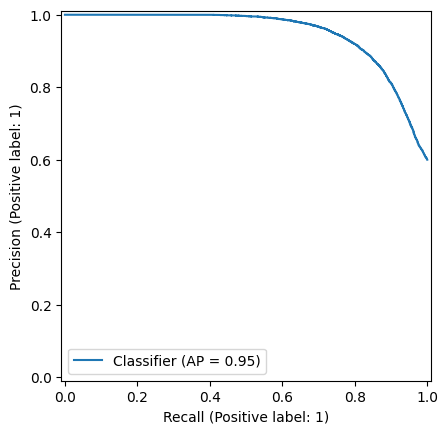

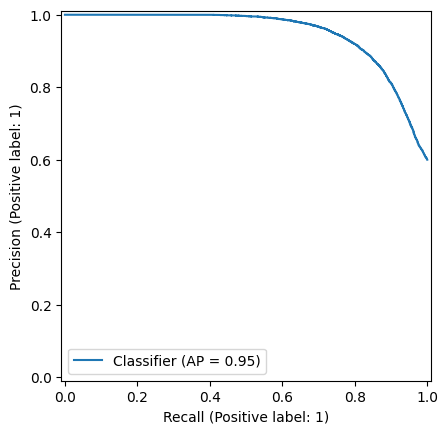

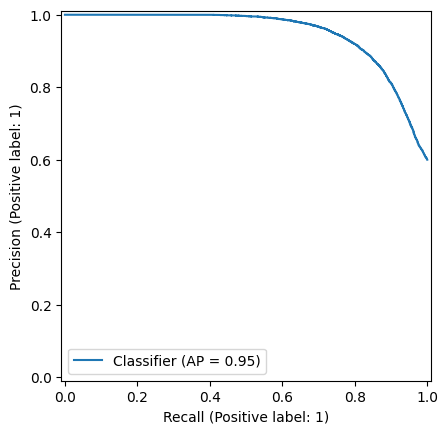

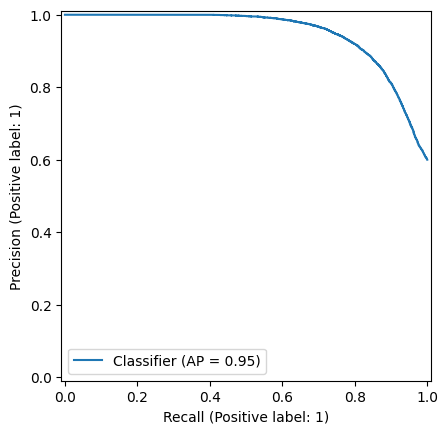

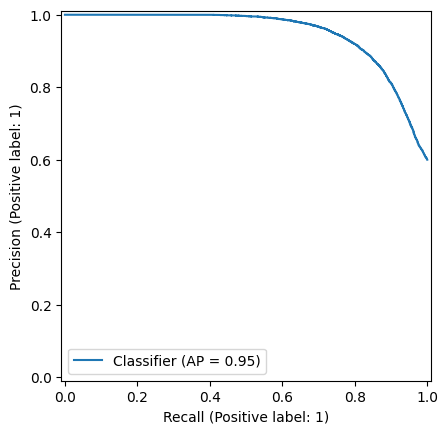

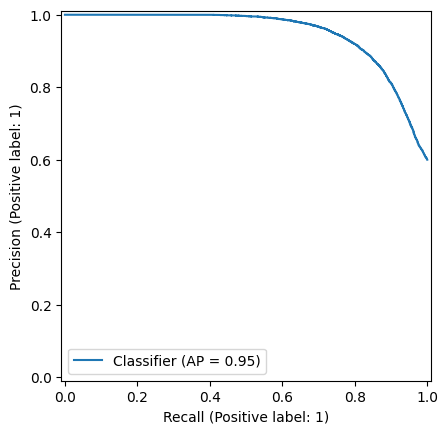

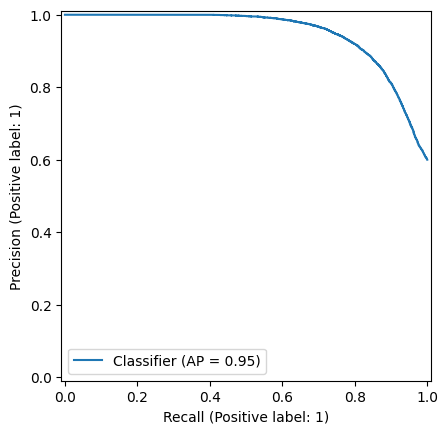

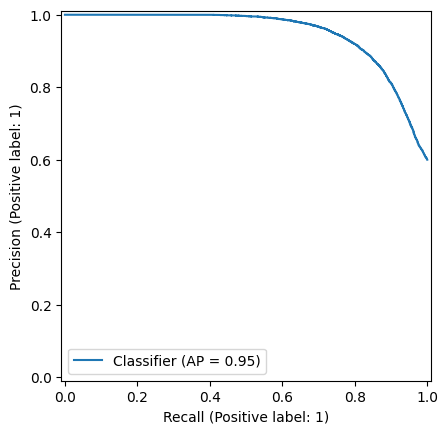

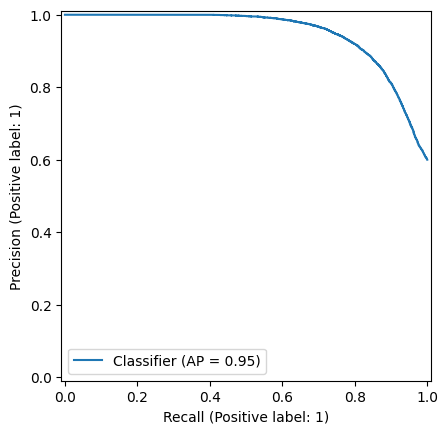

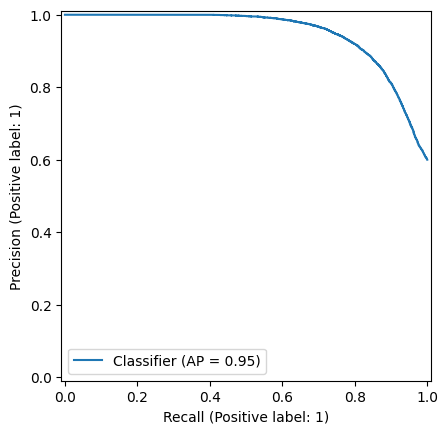

In [9]:
# SEGMENT FOR MODEL 11
candidate_features_11 = ['physical_activity_minutes_per_week', 'bmi', 'glucose_fasting', 'glucose_postprandial']
test_lr_model(candidate_features_11, 11)

# Up to 1000 max_iterations test: 
# max_iterations: 100
# Precision: 0.8494
# Recall: 0.8754